# Coronary Heart Disease Classifier

The heart study dataset contains risk factors as features that can be used to build predictive models. The task is to compare classification algorithms based on their performance and predict the risk of developing a heart disease. Consider the below mentioned features that are categorized by patient's Demographics, Behavioural and Medical history.

Features:

* Age
* Sex
* Chest pain type (4 values)
* Resting blood pressure
* Serum cholestoral in mg/dl
* Fasting blood sugar > 120 mg/dl
* Resting electrocardiographic results (values 0,1,2)
* Maximum heart rate achieved
* Exercise induced angina
* Oldpeak = ST depression induced by exercise relative to rest
* The slope of the peak exercise ST segment
* Number of major vessels (0-3) colored by flouroscopy
* Thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

Target variable (ordinal): 

Class 0: "Not at risk of heart disease" and Classes 1, 2, 3, 4:  "Risk of heart disease"

In [383]:
# Dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, roc_curve, precision_recall_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, chi2, f_regression
from sklearn.decomposition import PCA
# warning message

import warnings
warnings.filterwarnings("ignore")

In [384]:
# importing data

heart_data = pd.read_csv(r"C:\Users\Dell\Desktop\Heart_Study.csv")

heart_data.head()

,Age,Sex,ChestPain,RestingBloodPressure,Cholesterol,FastingBloodSugar,RestingECG,MaxHeartRate,ExerciseInducedAngina,ST_Depression,ST_Slope_Peak,MajorVessel,ThalliumStressTest,HeartDisease
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [385]:
heart_data.describe()

,Age,Sex,ChestPain,RestingBloodPressure,Cholesterol,FastingBloodSugar,RestingECG,MaxHeartRate,ExerciseInducedAngina,ST_Depression,ST_Slope_Peak,MajorVessel,ThalliumStressTest,HeartDisease
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [386]:
# Looking for missing values in the dataset
feature = []
missing = []
miss_perc = []

for var, miss_val in heart_data.isnull().sum().items():
    if miss_val>0:
        feature.append(var)
        missing.append(miss_val)
        miss_perc.append(miss_val*100/heart_data.shape[0])
        
# Dataframe for features with missing values
Miss_df = pd.DataFrame({'Missing Values':missing, 'In %': miss_perc}, index=feature).round(2)

# Exploratory Data Analysis

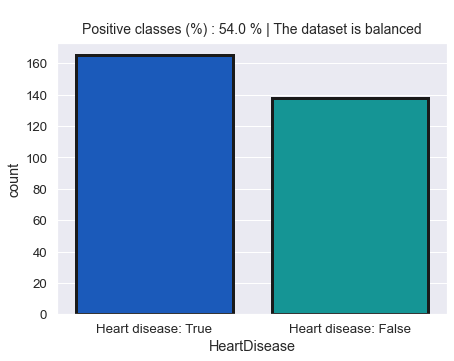

In [387]:
def Imbalance_data():
    
    pos = heart_data[heart_data['HeartDisease']==1] 
    neg = heart_data[heart_data['HeartDisease']==0]
    imbalance = pos.shape[0]/(pos.shape[0]+neg.shape[0])
    
    if imbalance>0.45 and imbalance<0.55:
        return ('\nPositive classes (%) : '+str(np.round(imbalance, 2)*100)+' %'+' | The dataset is balanced')
    else:
        return ('\nPositive classes (%) : '+str(np.round(imbalance, 2)*100)+' %'+' | The dataset is imbalanced')    
    
# Creating a temporary dataframe to be used for plotting
# Dropping nan values 
df_clean = heart_data.dropna(axis=0)
df_chd = df_clean['HeartDisease'].astype(str).replace({'0':'Heart disease: False', '1':'Heart disease: True'})
# List of categorical features
cont_features =  [col for col in df_clean.columns if len(df_clean[col].unique())>10]

# Plot
sns.set(font_scale=1.2)
plt.figure(figsize=(7,5))
ax = sns.countplot(df_chd, edgecolor='k', palette='winter', linewidth=3)
ax.set_title(Imbalance_data(), fontsize=14, y=1.01)
plt.show()

In [388]:
def Stackedbarplot(data, features, x_col, rows, cols):
    
    fig = plt.figure(figsize=(20, 20))
    
    for index, feature in enumerate(features):
        
            if feature !=x_col:
                ax = fig.add_subplot(rows, cols, index+1)
                sns.countplot(data=data, x=x_col, ax=ax, hue=feature, edgecolor='k', palette='gist_rainbow', linewidth=2)
                ax.set_title("Categorizing "+feature+" w.r.t. "+x_col,fontsize=18)
                ax.set_xlabel(x_col,fontsize=18)
                plt.legend(fontsize='large')
    
    plt.tight_layout()
    plt.show()
    
def Distribution(data, features, rows, cols):
    
    fig = plt.figure(figsize=(20, 20))
    
    for index, feature in enumerate(features):
        ax = fig.add_subplot(rows, cols, index+1)
        sns.distplot(data[feature],ax=ax,label='Skewness: %.2f'%data[feature].skew())
        ax.set_title(feature+" Distribution",fontsize=18)
        ax.set_xlabel(feature,fontsize=16)
        plt.legend(fontsize='large')
        
    plt.tight_layout()
    plt.show()

# Qualitative Analysis: Stacked Bar Plots

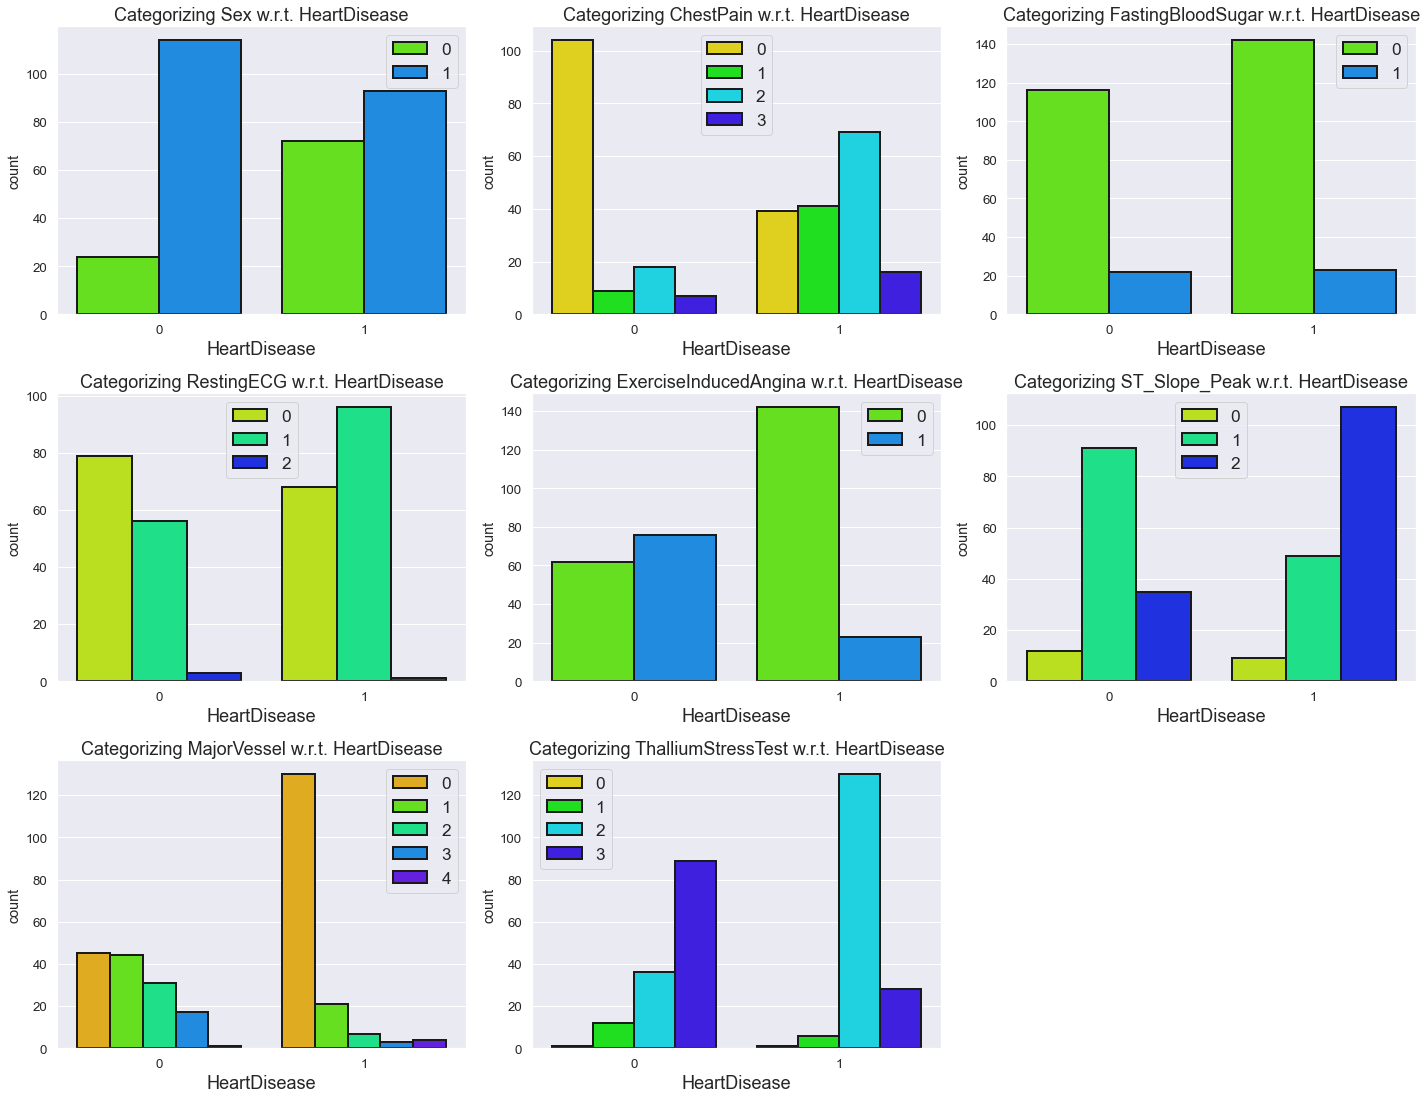

In [389]:
# List of categorical features
cat_features =  [col for col in df_clean.columns if len(df_clean[col].unique())<10]

# Dropping continuous features for the bar plot
categorical_features = df_clean.drop(columns=cont_features)
Stackedbarplot(categorical_features, categorical_features.columns, 'HeartDisease', 4, 3)

# Quantitative Analysis: Gaussian Distribution

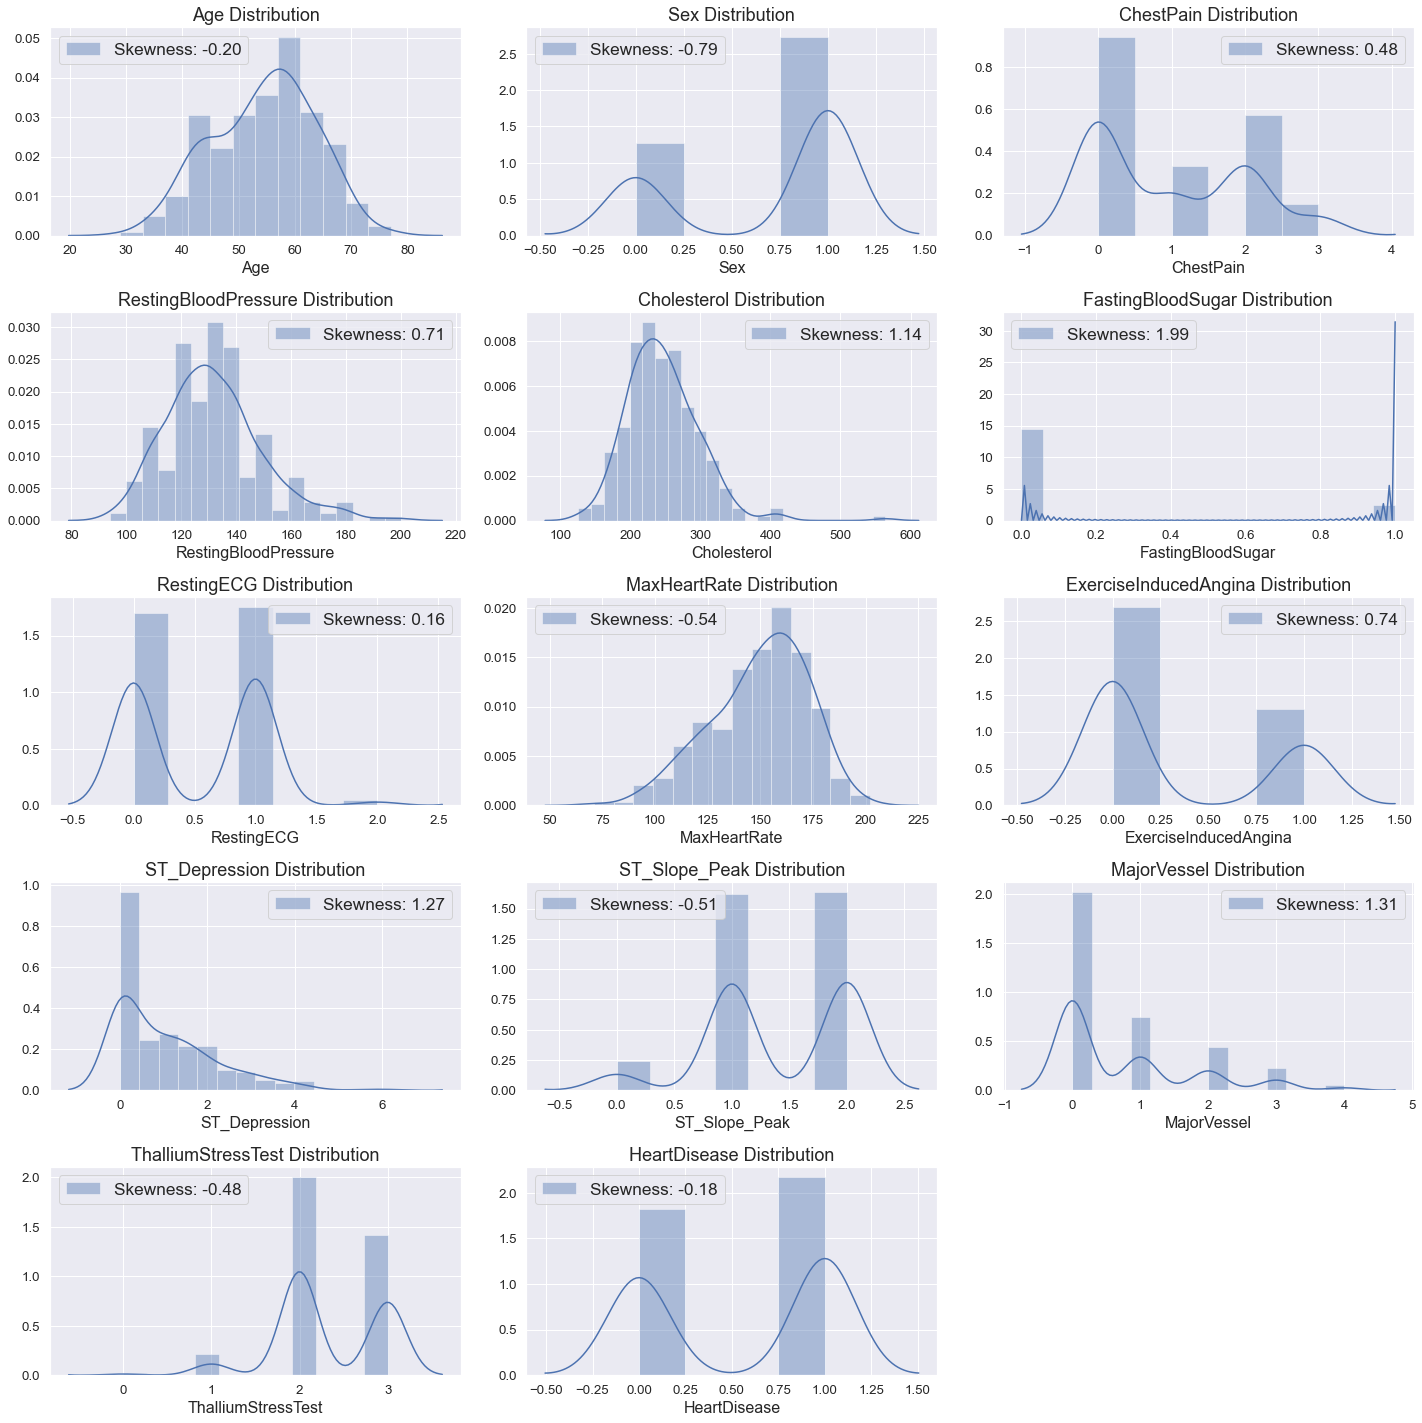

In [390]:
# Dropping categorical features for the Gaussian distributioon
continuous_features = df_clean
Distribution(continuous_features, continuous_features.columns, 5, 3)

# Data Cleaning

In [391]:
from sklearn.impute import SimpleImputer

# Imputing Continuous Feature
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
data_impute = imputer.fit_transform(heart_data[cont_features])
data_cont = pd.DataFrame(data_impute, columns=heart_data[cont_features].columns) 

# Imputing categorical Feature
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_impute = imputer.fit_transform(heart_data[cat_features])
data_cat = pd.DataFrame(data_impute, columns=heart_data[cat_features].columns) 

# Combine these seperate datasets into one
data_combined = pd.concat([data_cat,data_cont], axis=1)

In [392]:
# Creating N-1 dummy variables 

data = pd.get_dummies(data_combined, drop_first=True, columns=['ChestPain','RestingECG','ST_Slope_Peak','MajorVessel','ThalliumStressTest'])

# Model Building and Evaluation

In [393]:
# Dictionary of Classifiers 
Models = {"LogisticRegression": LogisticRegression(), "RandomForestClassifier": RandomForestClassifier(), "GradientBoostingClassifier": GradientBoostingClassifier()}

def Model_report(clf_name, xtrain, ytrain, xtest, threshold,predictors):
    
    # ML Algorithm to be used
    model = Models[clf_name]
    
    # Creating a pipeline to scale the model 
    pipeline = Pipeline([('Scaler',MinMaxScaler()), ('Classifier',model)])
    
    # Fit the model
    pipeline.fit(xtrain, ytrain)
    y_prob = pipeline.predict_proba(xtest)[:,1]
    y_pred = y_prob>threshold
    
    # Bar Plot for Feature Importance 
    if clf_name == 'LogisticRegression':
        plt.figure(figsize=(10,7))
        plt.bar(predictors.columns, model.coef_[0], color='lightgreen', edgecolor='k')
        plt.title("Feature Scores for %s"%clf_name)
        plt.xlabel("Features")
        plt.ylabel("Feature Importance")
        plt.xticks(rotation=90)
        plt.show()
   
    elif clf_name in ['RandomForestClassifier', 'GradientBoostingClassifier']:
        plt.figure(figsize=(10,7))
        plt.bar(predictors.columns, model.feature_importances_, color='lightgreen', edgecolor='k')
        plt.title("Feature Scores for %s"%clf_name)
        plt.xlabel("Features")
        plt.ylabel("Feature Importance")
        plt.xticks(rotation=90)
        plt.show()
        
    # Return the Classification report 
    print("| Classification Report for {} |".format(clf_name))
    return pd.DataFrame(classification_report(y_pred, y_test, output_dict=True)).round(2).T
    
def Cross_validation(independent,target,metric):
    
    # Dictionary of cross validation scores
    scores_dict = {}
    
    # Lists to store model name and calculations
    models_list = []
    score_mean = []
    score_dev = []
    score_min = []
    score_max = []
    
    for model_name, model in Models.items():
        
        # Creating a pipeline to scale the model 
        pipeline = Pipeline([('scaler', MinMaxScaler()), ('classifier', model)])
        
        # Calculating cross validation scores
        cvscore = cross_val_score(pipeline, independent, target, cv=5, scoring=metric)
        
        score_mean.append(cvscore.mean())
        score_dev.append(cvscore.std(ddof=0))
        score_min.append(np.min(cvscore))
        score_max.append(np.max(cvscore))
        
        # Updating Score_dict with min & max values and mean & Standard deviation of the metric score
        scores_dict.update({'CV Score: Mean': score_mean})
        scores_dict.update({'CV Score: Deviation': score_dev})
        scores_dict.update({'CV Score: Min': score_min})
        scores_dict.update({'CV Score: Max': score_max})   
        
        # Creating a list of model names
        models_list.append(model_name)
        
    print("| Cross Validation Scores | Scoring metric: {} |".format(metric))  
    scores_df = pd.DataFrame(scores_dict, index=[models_list]).round(4)
    
    return scores_df

# Parameters tuning for Logistic Regression

def model_tuning(clf_name, predictors, target):
    
    # Initializing classifier from the 'Models' dictionary
    model = Models[clf_name]
    
    # Creating a search space
    search_space = dict()
    
    if clf_name == 'LogisticRegression':
        search_space['penalty'] = ['l1', 'l2', 'elasticnet']
        search_space['C'] = [1e-3, 1e-2, 1e-1, 1, 10, 100]
        search_space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
        search_space['max_iter'] = [100, 300, 500]
       
    if clf_name == 'RandomForestClassifier':
        search_space['n_estimators'] = [100, 300, 500]
        search_space['criterion'] = ['gini','entropy']
        search_space['max_depth'] = [int(depth) for depth in np.linspace(start=10,stop=50,num=10)]
        search_space['min_samples_split'] = [2, 10, 20]
        search_space['min_samples_leaf'] = [1, 2, 4]
        search_space['max_features'] = ['auto', 'sqrt', 'log2']
        search_space['bootstrap'] = ['True', 'False']
        
    if clf_name == 'GradientBoostingClassifier':
        
        search_space['learning_rate'] = [1e-3,1e-2,1e-1]
        search_space['n_estimators'] = [int(n) for n in np.linspace(start=100,stop=500,num=10)]
        search_space['criterion'] = ['gini','entropy']
        search_space['max_depth'] = [int(depth) for depth in np.linspace(start=10,stop=100,num=10)]
        search_space['min_samples_split'] = [2, 10, 20]
        search_space['min_samples_leaf'] = [1, 2, 4]
        search_space['max_features'] = ['auto', 'sqrt']
    
    grid_search = GridSearchCV(model, search_space, scoring='f1_macro', n_jobs=-1, cv=5)
    
    result = grid_search.fit(predictors, target)
    
    print("| Hyperparameter Tuning: {} | \n\nBest Score: {}".format(clf_name,np.round(result.best_score_,2)))
    
    return pd.DataFrame(result.best_params_, index=['Best Parameters']).T    

# Model Results

In [394]:
# Slicing data into Predictor and Target variables
X = data.drop(columns=['HeartDisease'])
y = data['HeartDisease'].values

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=1)

In [395]:
Cross_validation(X,y,'f1_macro')

| Cross Validation Scores | Scoring metric: f1_macro |


,CV Score: Mean,CV Score: Deviation,CV Score: Min,CV Score: Max
LogisticRegression,0.8423,0.0374,0.7943,0.9014
RandomForestClassifier,0.8031,0.0255,0.7803,0.8518
GradientBoostingClassifier,0.8040,0.0445,0.7413,0.8671


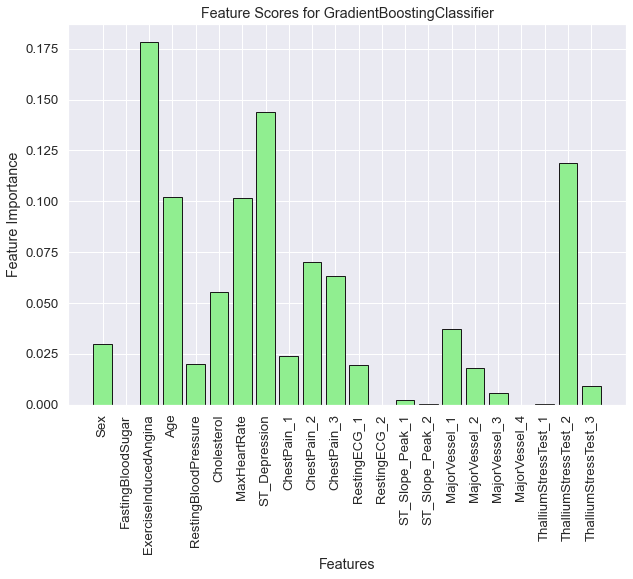

| Classification Report for GradientBoostingClassifier |


,precision,recall,f1-score,support
False,0.70,0.73,0.71,44.00
True,0.78,0.75,0.76,56.00
accuracy,0.74,0.74,0.74,0.74
macro avg,0.74,0.74,0.74,100.00
weighted avg,0.74,0.74,0.74,100.00


In [396]:
Model_report('GradientBoostingClassifier',X_train,y_train,X_test,0.5,predictors)

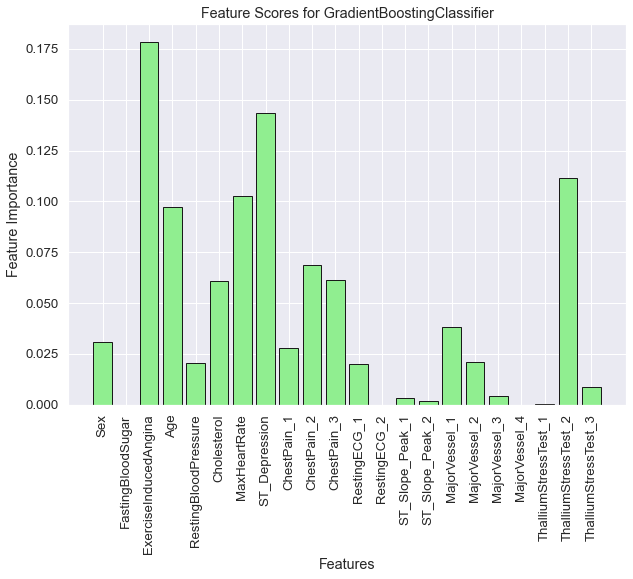

| Classification Report for GradientBoostingClassifier |


,precision,recall,f1-score,support
False,0.72,0.73,0.73,45.00
True,0.78,0.76,0.77,55.00
accuracy,0.75,0.75,0.75,0.75
macro avg,0.75,0.75,0.75,100.00
weighted avg,0.75,0.75,0.75,100.00


In [397]:
Model_report('GradientBoostingClassifier',X_train,y_train,X_test,0.5,predictors)

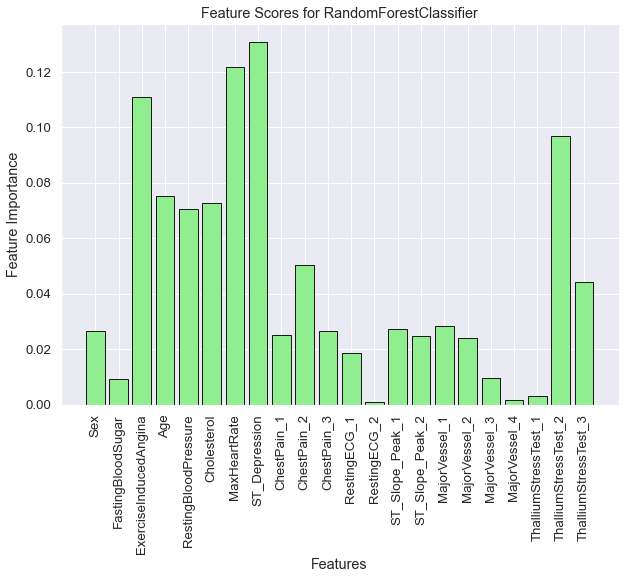

| Classification Report for RandomForestClassifier |


,precision,recall,f1-score,support
False,0.78,0.77,0.77,47.00
True,0.80,0.81,0.80,53.00
accuracy,0.79,0.79,0.79,0.79
macro avg,0.79,0.79,0.79,100.00
weighted avg,0.79,0.79,0.79,100.00


In [398]:
Model_report('RandomForestClassifier',X_train,y_train,X_test,0.5,predictors)

# Hyper-parameter tuning

In [399]:
# Logistic Regression performed better based on f1-score
# Calling model_tuning functon 
model_tuning('LogisticRegression', X, y)

| Hyperparameter Tuning: LogisticRegression | 

Best Score: 0.85


,Best Parameters
C,1
max_iter,300
penalty,l2
solver,lbfgs


In [400]:
# Logistic Regression with optimum parameters
# Classification report
clf = LogisticRegression(C= 1, 
                         max_iter= 300, 
                         penalty='l2', 
                         solver = 'lbfgs')

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]
                         
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81        45
           1       0.85      0.84      0.84        55

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100



# ROC CURVE AND AUC SCORE

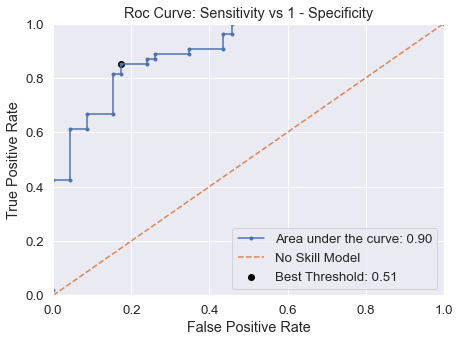

In [401]:
# Plotting ROC Curve for optimum threshold

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Index where (TPR-FPR) is maximum
index = np.argmax(tpr-fpr)
auc_score = roc_auc_score(y_test, y_prob)

sns.set_style('dark')
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, marker='.', label='Area under the curve: %.2f' %auc_score)
plt.scatter(fpr[index], tpr[index], marker='o', color='black', label='Best Threshold: %.2f' %thresholds[index])
plt.plot([0.0, 1.0], [0.0, 1.0], linestyle='--', label='No Skill Model')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Roc Curve: Sensitivity vs 1 - Specificity")
plt.legend()
plt.grid(True)
plt.show()

# Conclusion

The model has performed well and following are the results:

* Logistic Regression performed better than Random forest and Gradient boosting in terms of F1-score.
* Model achieved F1-score of 0.84 and an accuracy of 0.83 (the dataset is balanced).
* Area under the roc curve is 0.90 which means the model has better sensitivity than specificity.
* From the roc curve we got best threshold value of 0.51 for the model.

> This is a bonafide work of Aarush Gandhi.